In [4]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from math import sqrt
from scipy.stats import wilcoxon, friedmanchisquare

## Exercise 1 - Exploratory Analysis

### 1) Dataset Load and Data Summary

In [5]:
# Dataset load, info and data summary
df = pd.read_csv('../data/AIRPOL_data.csv', delimiter=";", header=0, usecols=[*range(0,8)], decimal=',')
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49140 entries, 0 to 49139
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country                       49140 non-null  object 
 1   NUTS_Code                     49140 non-null  object 
 2   Air_Pollutant                 49140 non-null  object 
 3   Outcome                       49140 non-null  object 
 4   Affected_Population           49140 non-null  float64
 5   Populated_Area[km2]           49140 non-null  float64
 6   Air_Pollution_Average[ug/m3]  49140 non-null  float64
 7   Value                         49140 non-null  float64
dtypes: float64(4), object(4)
memory usage: 3.0+ MB


,Affected_Population,Populated_Area[km2],Air_Pollution_Average[ug/m3],Value
count,4.914000e+04,4.914000e+04,49140.000000,49140.000000
mean,1.023692e+06,6.534426e+03,15.138166,366.798657
std,9.085726e+06,5.661679e+04,22.579360,5494.481929
min,2.674000e+03,2.000000e+00,0.100000,0.000000
25%,1.069040e+05,5.697000e+02,7.200000,3.000000
50%,2.388280e+05,1.340100e+03,8.900000,23.000000
75%,5.988800e+05,4.215200e+03,11.400000,112.000000
max,4.680626e+08,2.687568e+06,125.700000,740933.000000


### 2) Graphic exploration

In [6]:
# Filter the data so only the data of NUTS level 3 is studied

regex = r"^([A-Z]{2}[0-9]{3})"
df = df[df['NUTS_Code'].str.contains(regex)]
df.drop_duplicates
df.describe()

C:\Users\jfcar\AppData\Local\Temp\ipykernel_23532\1660861360.py:4: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df = df[df['NUTS_Code'].str.contains(regex)]


,Affected_Population,Populated_Area[km2],Air_Pollution_Average[ug/m3],Value
count,2.289900e+04,22899.000000,22899.000000,22899.000000
mean,2.790747e+05,1699.496262,15.253072,107.709769
std,4.049825e+05,2350.481411,22.278349,373.536537
min,2.674000e+03,11.200000,0.100000,0.000000
25%,9.163900e+04,478.800000,7.300000,2.000000
50%,1.763820e+05,901.800000,9.100000,15.000000
75%,3.379320e+05,2006.500000,11.700000,69.000000
max,9.488545e+06,36826.000000,112.600000,12289.000000


#### Univariate Analysis

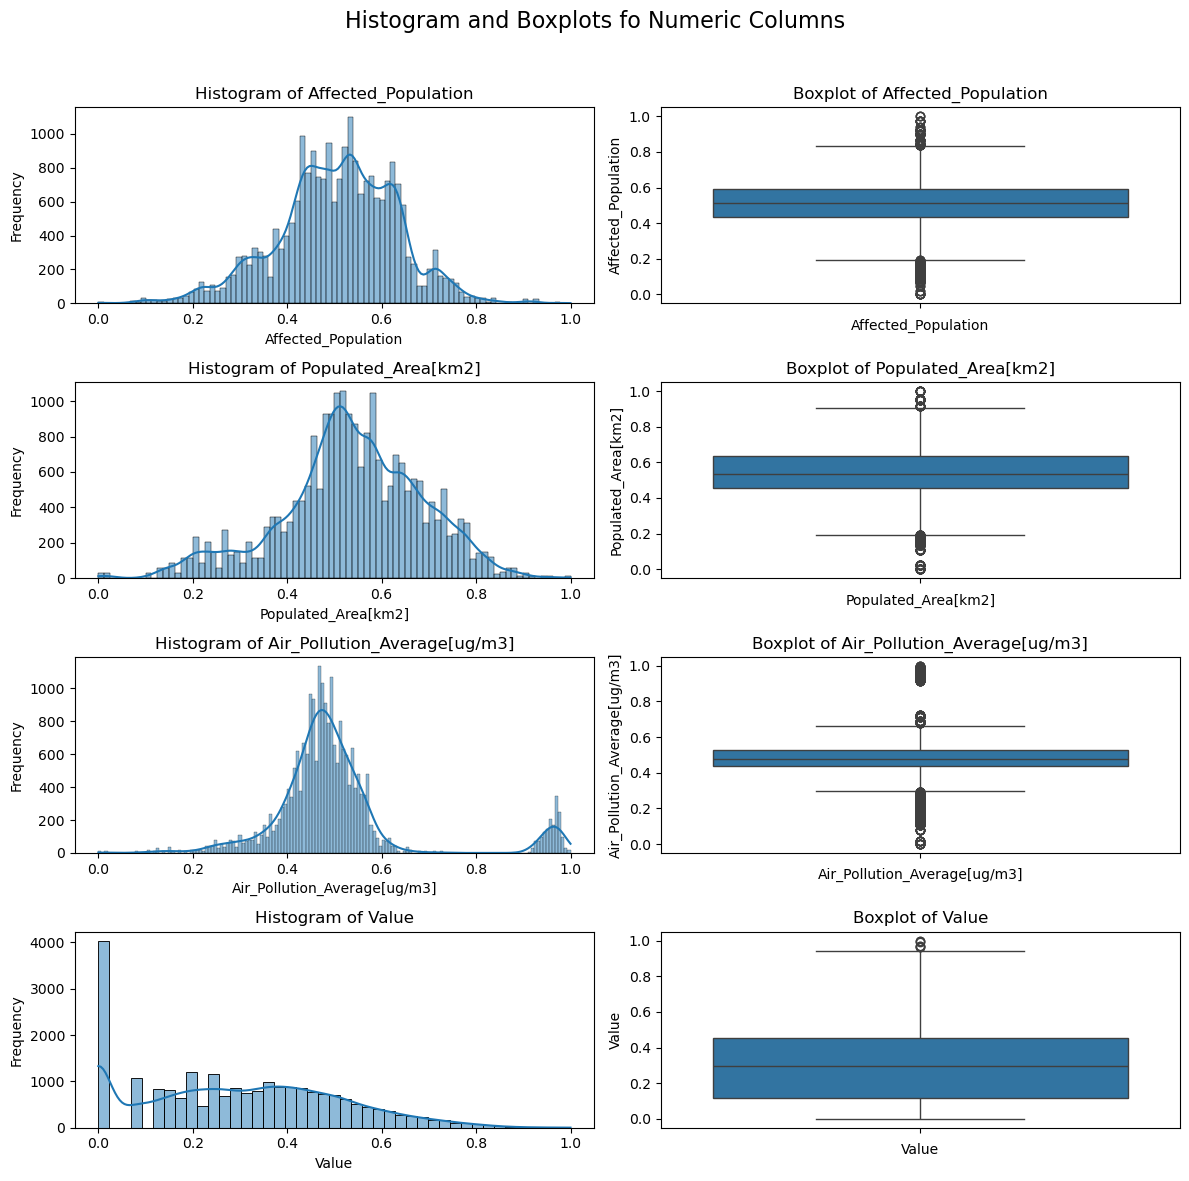

In [7]:
numericFeatures = ["Affected_Population", "Populated_Area[km2]", "Air_Pollution_Average[ug/m3]", "Value"]

# Apply log1p (log(1 + x)) to reduce the impact of extreme values
df_log = df[numericFeatures].apply(lambda x: np.log1p(x))

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_log), columns=numericFeatures)
numFeatures = len(numericFeatures)

# define layout for subplots
fig, axes = plt.subplots(nrows= numFeatures, ncols = 2, figsize=(12, 3 * numFeatures))
fig.suptitle('Histogram and Boxplots fo Numeric Columns', fontsize = 16)

# Loop through each column and create plots
for i, column in enumerate(numericFeatures):
    # Histogram
    sns.histplot(df_scaled[column], ax = axes[i, 0], kde=True)
    axes[i, 0].set_title(f"Histogram of {column}")
    axes[i, 0].set_xlabel(column)
    axes[i, 0].set_ylabel("Frequency")

    # Boxplot
    sns.boxplot(y=df_scaled[column], ax=axes[i, 1])
    axes[i, 1].set_title(f"Boxplot of {column}")
    axes[i, 1].set_xlabel(column)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

<Axes: xlabel='Country', ylabel='Número de Mortes Prematuras (em milhões)'>

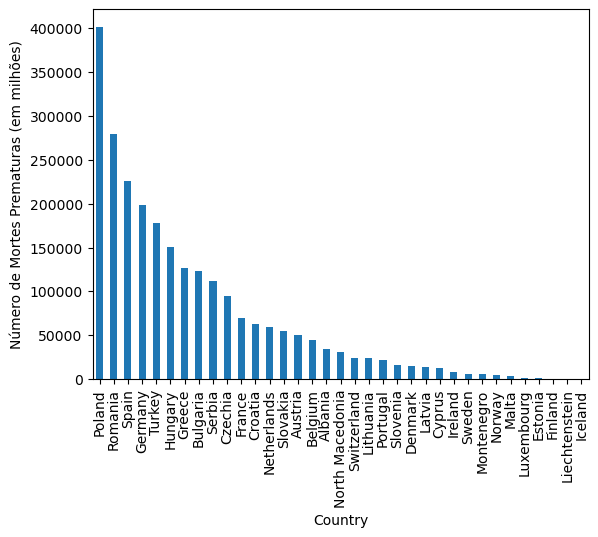

In [8]:
# This isn't an adequate graphic, needs to be in the millions
data_compare_deaths = df.drop(['Outcome','Affected_Population','Populated_Area[km2]'], axis = 1).drop_duplicates().drop(['NUTS_Code'], axis = 1).groupby("Country")["Value"].sum().sort_values(ascending=False)
data_compare_deaths.plot.bar(ylabel = 'Número de Mortes Prematuras (em milhões)')

### Bivariate Analysis

In [9]:
# goal attribute = value (number of premature deaths)
goalAttrib = 'Value'

numericFeatures = ["Affected_Population", "Populated_Area[km2]", "Air_Pollution_Average[ug/m3]"]

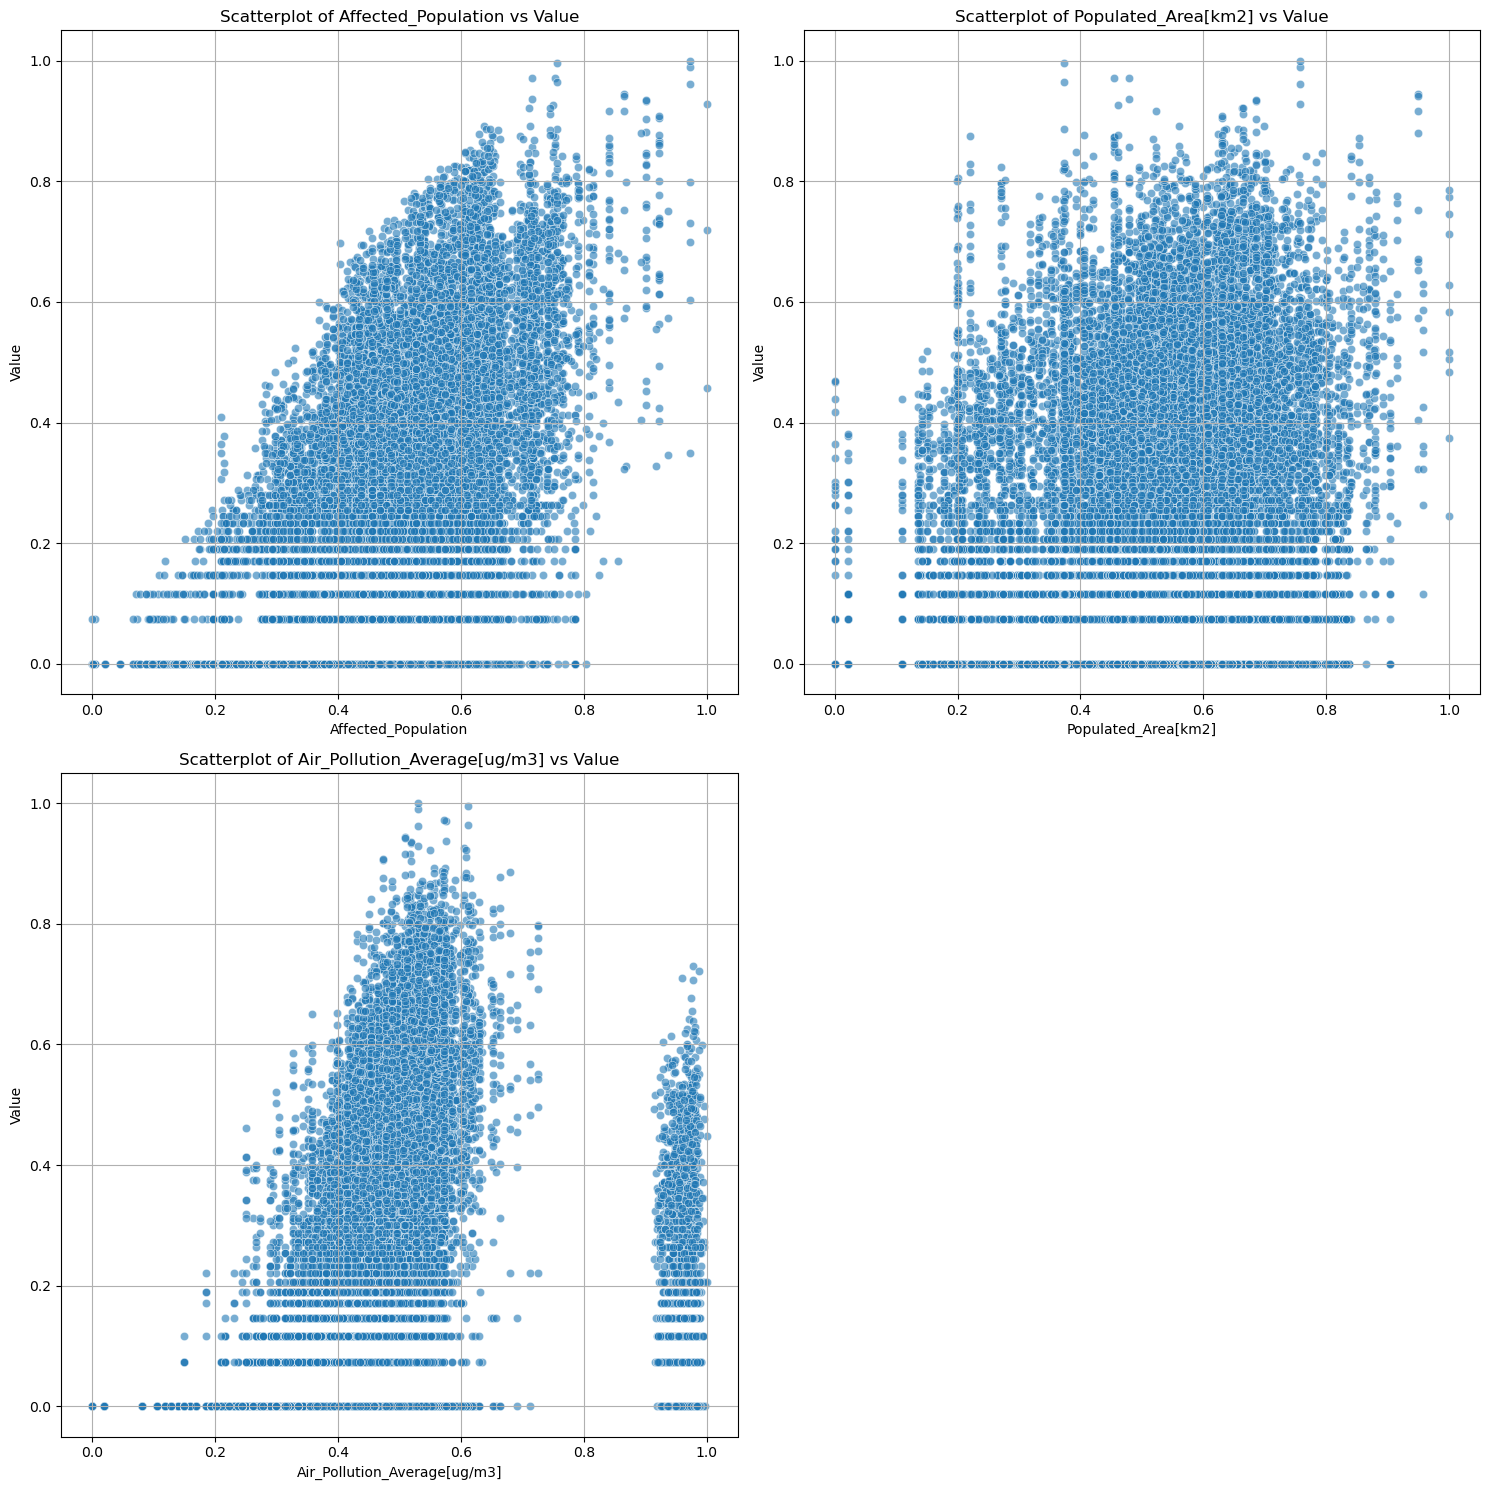

In [10]:
plt.figure(figsize=(15, 15))
for i, feature in enumerate(numericFeatures):
    rows = (len(numericFeatures) + 1) // 2 # Adjust rows to handle odd number of features

    plt.subplot(rows, 2, i + 1)

    sns.scatterplot(x=df_scaled[feature], y=df_scaled[goalAttrib], alpha=0.6)

    plt.title(f"Scatterplot of {feature} vs {goalAttrib}")
    plt.xlabel(feature)
    plt.ylabel(goalAttrib)
    plt.grid()

    # Create the boxplot using the palette
    # sns.boxplot(x='strength', y=feature, hue='strength', data=df)

plt.tight_layout()

### 3) Pre-processing

### 4) Country groups

In [11]:
western_europe = ["Austria", "Belgium", "France", "Germany", "Netherlands", "Switzerland"]
eastern_europe = ["Poland", "Czechia", "Hungary"]
southern_europe = ["Spain", "Portugal", "Italy", "Greece"]
northern_europe = ["Sweden", "Denmark", "Northern Europe", "Finland"]

## Exercise 2 - Regression

### 1) Correlation Diagram

In [12]:
df_se = df[df['Country'].isin(southern_europe)].copy()

In [13]:
df_se.rename(columns={'Value': 'Premature_Deaths'}, inplace=True)
numeric_cols = ['Affected_Population', 'Populated_Area[km2]', 'Air_Pollution_Average[ug/m3]', 'Premature_Deaths']
correlation = df_se[numeric_cols].corr()['Premature_Deaths'].drop('Premature_Deaths').sort_values(ascending=True)

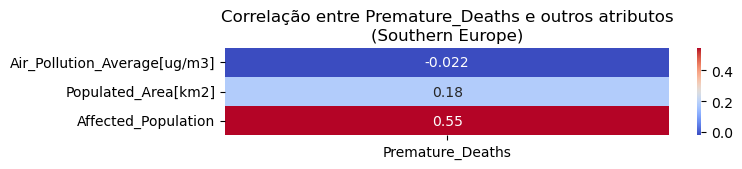

In [14]:
plt.figure(figsize=(8, len(correlation) * 0.6))
sns.heatmap(correlation.to_frame(), annot=True, cmap='coolwarm', cbar=True)
plt.title('Correlação entre Premature_Deaths e outros atributos\n(Southern Europe)')
plt.tight_layout()
plt.show()

Interpretação:

1 - Premature_Deaths tem alta correlação comn Affected Population (r = 0.55)

2 - Premature_Deaths tem correlação muito baixa com Air_Pollution_Average (r = -0.022)

### 2) k-fold cross validation - linear regression

In [15]:
X = df_se[['Affected_Population']].values  # Variável independente (X)
y = df_se['Premature_Deaths'].values       # Variável dependente (y)

kf = KFold(n_splits=10, shuffle=True, random_state=42)

maes = []
rmses = []
coefs = []
intercepts = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
   
    maes.append(mean_absolute_error(y_test, y_pred))
    rmses.append(sqrt(mean_squared_error(y_test, y_pred)))
    coefs.append(model.coef_[0])
    intercepts.append(model.intercept_)

avg_coef = np.mean(coefs)
avg_intercept = np.mean(intercepts)
avg_mae = np.mean(maes)
avg_rmse = np.mean(rmses)

#### a) Linear function

In [16]:
print(f"Função linear média: Premature_Deaths = {avg_coef:.4f} * Affected_Population + {avg_intercept:.4f}")

Função linear média: Premature_Deaths = 0.0003 * Affected_Population + -1.9674


#### b) Simple Linear Regression and Dispersion Diagram

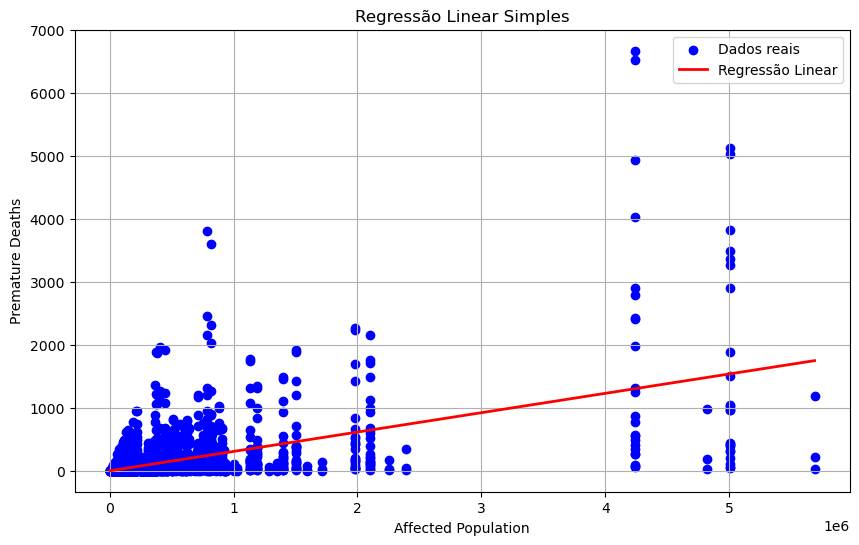

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Dados reais')
x_line = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
y_line = avg_coef * x_line + avg_intercept
plt.plot(x_line, y_line, color='red', linewidth=2, label='Regressão Linear')
plt.xlabel('Affected Population')
plt.ylabel('Premature Deaths')
plt.title('Regressão Linear Simples')
plt.legend()
plt.grid(True)
plt.show()

#### c) Error Metrics

In [18]:
print(f"Erro Médio Absoluto (MAE): {avg_mae:.2f}")
print(f"Raiz Quadrada do Erro Médio (RMSE): {avg_rmse:.2f}")

Erro Médio Absoluto (MAE): 119.90
Raiz Quadrada do Erro Médio (RMSE): 308.99


### 3) k-fold cross validation - prediction methods

#### a) Multiple Linear Regression

In [19]:
# Selection of predictor variable for MLR
features = ['Affected_Population', 'Populated_Area[km2]', 'Air_Pollution_Average[ug/m3]']
X = df_se[features].values
y = df_se['Premature_Deaths'].values

kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [20]:
maes_lr = []
rmses_lr = []

for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)

    maes_lr.append(mean_absolute_error(y_test, y_pred))
    rmses_lr.append(np.sqrt(mean_squared_error(y_test, y_pred)))

print("Regressão Linear Múltipla")
print(f"MAE médio: {np.mean(maes_lr):.2f}")
print(f"RMSE médio: {np.mean(rmses_lr):.2f}")

Regressão Linear Múltipla
MAE médio: 122.55
RMSE médio: 311.35


#### b) Regression Tree


Árvore de Regressão
Melhores parâmetros: {'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 10}
MAE médio: 113.59
RMSE médio: 314.59


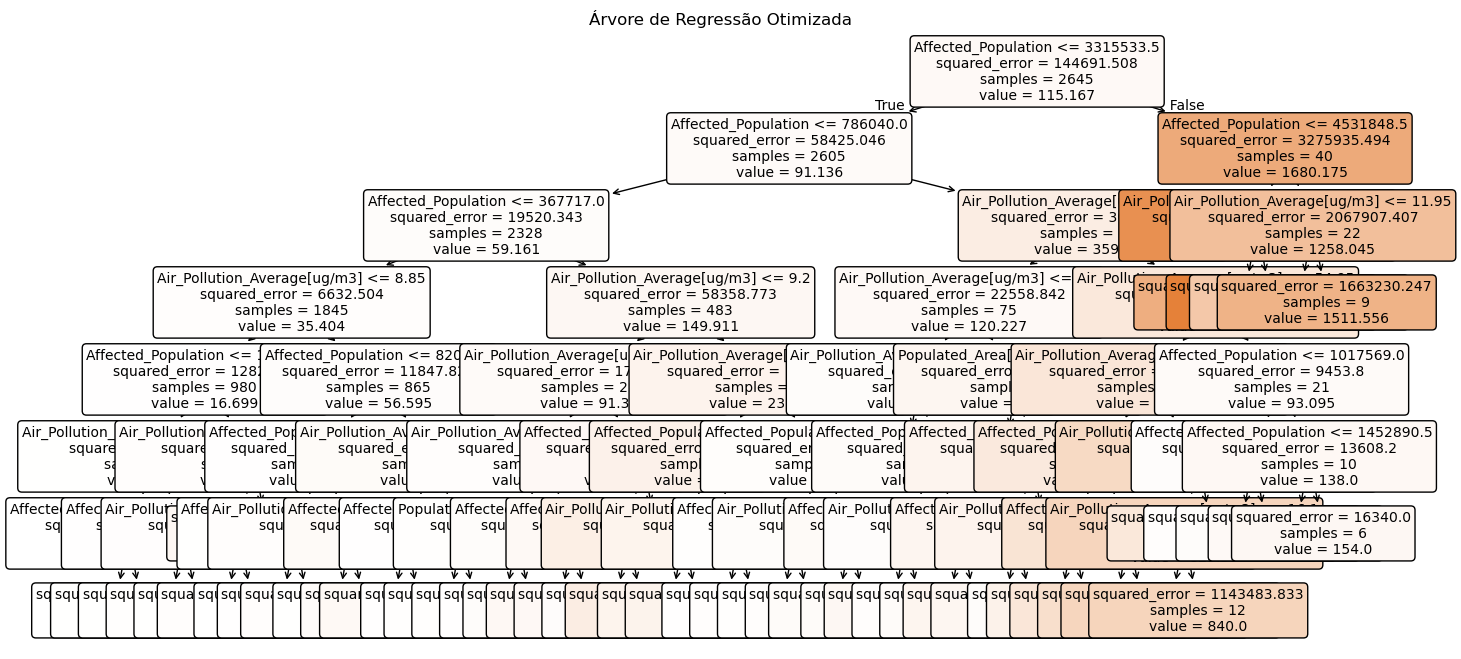

In [21]:
# --- b) Árvore de Regressão com otimização de parâmetros ---

param_grid = {
    'max_depth': [3, 5, 7, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(dt, param_grid, cv=kf, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

best_dt = grid_search.best_estimator_

print("\nÁrvore de Regressão")
print(f"Melhores parâmetros: {grid_search.best_params_}")

# Avaliação da melhor árvore com K-Fold
maes_dt = []
rmses_dt = []
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    best_dt.fit(X_train, y_train)
    y_pred = best_dt.predict(X_test)

    maes_dt.append(mean_absolute_error(y_test, y_pred))
    rmses_dt.append(np.sqrt(mean_squared_error(y_test, y_pred)))

print(f"MAE médio: {np.mean(maes_dt):.2f}")
print(f"RMSE médio: {np.mean(rmses_dt):.2f}")

# Visualizar a árvore
plt.figure(figsize=(16,8))
plot_tree(best_dt, feature_names=features, filled=True, rounded=True, fontsize=10)
plt.title("Árvore de Regressão Otimizada")
plt.show()

#### c) SVM

In [22]:
# SVM requires scaled data

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [23]:
kernels = ['linear', 'rbf', 'poly']

results = []

for kernel in kernels:
    # initialization and training
    svm_model = SVC(kernel=kernel, random_state=42)

    acc_scores = cross_val_score(svm_model, X_train_scaled, y_train, scoring='accuracy', cv=10)

    # store results
    results[kernel] = {
        'accuracy':acc_scores
    }

    print(f"\nKernel: {kernel}")
    print(f"Avg. accuracy: {round(np.mean(acc_scores), 3)} +/- {round(np.std(acc_scores), 3)}")

    # Classification reports

    svm_model.fit(X_train_scaled, y_train)

    y_pred = svm_model.predict(X_test_scaled)

    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


TypeError: list indices must be integers or slices, not str

#### d) Neural Network

In [ ]:
# --- d) Rede Neural com otimização da configuração ---

param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50,50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'max_iter': [500]
}

mlp = MLPRegressor(random_state=42)
grid_search_mlp = GridSearchCV(mlp, param_grid_mlp, cv=kf, scoring='neg_mean_squared_error', refit=True)
grid_search_mlp.fit(X, y)

best_mlp = grid_search_mlp.best_estimator_

print("\nRede Neural")
print(f"Melhores parâmetros: {grid_search_mlp.best_params_}")
maes_mlp = []
rmses_mlp = []
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    best_mlp.fit(X_train, y_train)
    y_pred = best_mlp.predict(X_test)

    maes_mlp.append(mean_absolute_error(y_test, y_pred))
    rmses_mlp.append(np.sqrt(mean_squared_error(y_test, y_pred)))

print(f"MAE médio: {np.mean(maes_mlp):.2f}")
print(f"RMSE médio: {np.mean(rmses_mlp):.2f}")


Rede Neural
Melhores parâmetros: {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (50, 50), 'max_iter': 500, 'solver': 'adam'}
MAE médio: 116.23
RMSE médio: 319.22


## Exercise 3 - Classification

### 1) New Attribute and Disease Separation

In [ ]:
# Criar a nova coluna RespDisease com base no Outcome
respiratory_conditions = ['Asthma', 'Chronic obstructive pulmonary disease']

df['RespDisease'] = df['Outcome'].apply(
    lambda x: 'Respiratory' if x in respiratory_conditions else 'Non-respiratory'
)

# Verificar os primeiros valores
print(df[['Outcome', 'RespDisease']].head())
df.rename(columns={'Value': 'Premature_Deaths'}, inplace=True)

   Outcome  RespDisease
10  Asthma  Respiratory
11  Asthma  Respiratory
12  Asthma  Respiratory
13  Asthma  Respiratory
14  Asthma  Respiratory


### 2) k-fold cross validation - prediction methods

In [ ]:
# Converter o alvo para binário
df['RespDisease'] = df['RespDisease'].map({'Respiratory': 1, 'Non-respiratory': 0})

# Features
X = df[['Affected_Population', 'Populated_Area[km2]', 'Air_Pollution_Average[ug/m3]']]
y = df['RespDisease']

# K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

#### a) Decision Tree

Árvore de Decisão
Melhores parâmetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Exatidão média: 0.8956723832266344


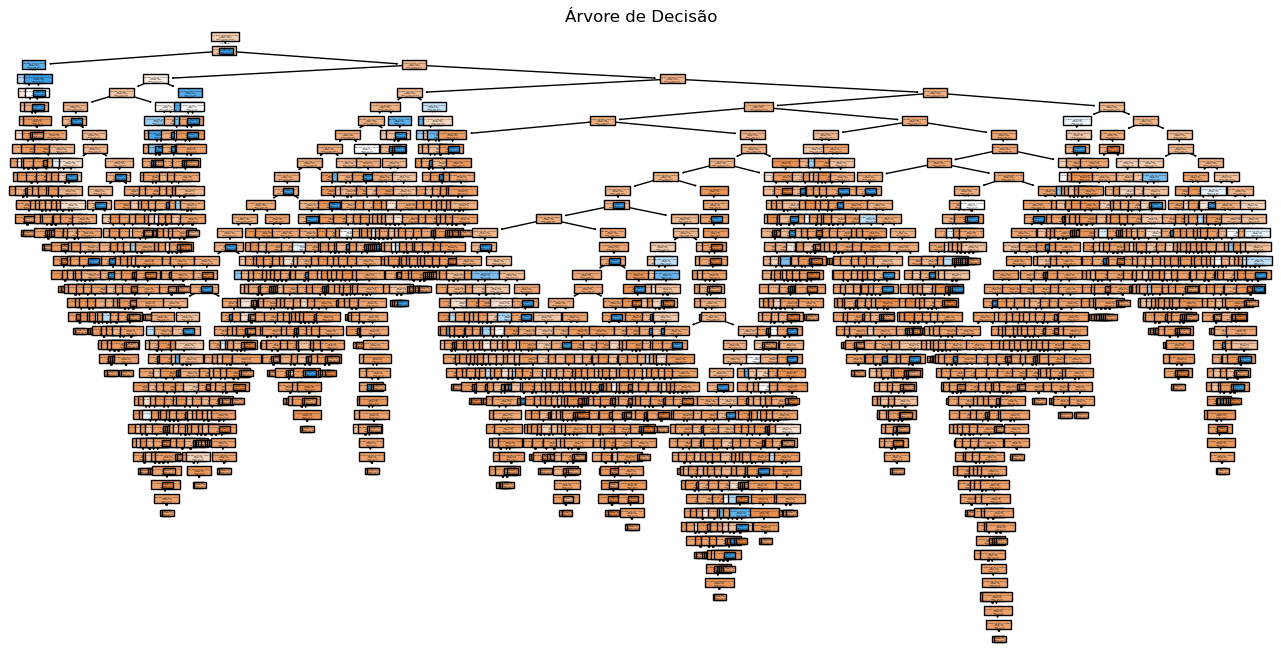

In [ ]:
param_grid_tree = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt = DecisionTreeClassifier(random_state=42)
grid_tree = GridSearchCV(dt, param_grid_tree, cv=kf, scoring='accuracy')
grid_tree.fit(X, y)

print("Árvore de Decisão")
print("Melhores parâmetros:", grid_tree.best_params_)
print("Exatidão média:", grid_tree.best_score_)

# Visualizar árvore
plt.figure(figsize=(16,8))
plot_tree(grid_tree.best_estimator_, feature_names=X.columns, class_names=['Non', 'Resp'], filled=True)
plt.title("Árvore de Decisão")
plt.show()

#### b) Neural Network

In [ ]:
 ### TO BE CHANGED - SHOULD BE NEURAL NETWORK
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50,50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],
    'max_iter': [300]
}

mlp = MLPClassifier(random_state=42)
grid_mlp = GridSearchCV(mlp, param_grid_mlp, cv=kf, scoring='accuracy')
grid_mlp.fit(X, y)

print("\nRede Neural")
print("Melhores parâmetros:", grid_mlp.best_params_)
print("Exatidão média:", grid_mlp.best_score_)



Rede Neural
Melhores parâmetros: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'max_iter': 300}
Exatidão média: 0.6908608313441562


#### c) SVM

In [ ]:
# SVM requires scaled data

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [ ]:
kernels = ['linear', 'rbf', 'poly']

results = []

for kernel in kernels:
    # initialization and training
    svm_model = SVC(kernel=kernel, random_state=42)

    acc_scores = cross_val_score(svm_model, X_train_scaled, y_train, scoring='accuracy', cv=10)

    # store results
    results[kernel] = {
        'accuracy':acc_scores
    }

    print(f"\nKernel: {kernel}")
    print(f"Avg. accuracy: {round(np.mean(acc_scores), 3)} +/- {round(np.std(acc_scores), 3)}")

    # Classification reports

    svm_model.fit(X_train_scaled, y_train)

    y_pred = svm_model.predict(X_test_scaled)

    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")

#### d) K-closest-neighbours

In [ ]:
param_grid_knn = {
    'n_neighbors': list(range(1, 11)),
    'weights': ['uniform', 'distance']
}

knn = KNeighborsClassifier()
grid_knn = GridSearchCV(knn, param_grid_knn, cv=kf, scoring='accuracy')
grid_knn.fit(X, y)

print("\nKNN")
print("Melhores parâmetros:", grid_knn.best_params_)
print("Exatidão média:", grid_knn.best_score_)


KNN
Melhores parâmetros: {'n_neighbors': 6, 'weights': 'distance'}
Exatidão média: 0.881872522270361
